In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno_interp import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [4]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [5]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [6]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(alpha_aux=[Normal(0,2), Normal(0,2)]),
               LossTracker(),SaveBest('weights/best_ii3.h5'),EarlyStopping(10)])

1: Train=741.0620330810547 Valid=631.7718054199219
2: Train=560.2094979858398 Valid=516.2187799072266
3: Train=488.15295043945315 Valid=474.3670129394531
4: Train=453.67906951904297 Valid=449.22460021972654
5: Train=431.90840423583984 Valid=430.93340270996094
6: Train=413.9879595947266 Valid=414.9292004394531
7: Train=401.22624420166017 Valid=406.07136474609376
8: Train=389.2871878051758 Valid=398.7525079345703
9: Train=380.77076599121096 Valid=390.73919372558595
10: Train=374.41562927246093 Valid=384.00737915039065
11: Train=367.69967864990235 Valid=379.8289892578125
12: Train=364.70906707763675 Valid=374.5228955078125
13: Train=359.2706018066406 Valid=370.7027227783203
14: Train=355.7881100463867 Valid=367.56634338378905
15: Train=352.72839508056643 Valid=365.78244140625
16: Train=350.09345153808596 Valid=362.15166625976565
17: Train=347.53006072998045 Valid=359.7821984863281
18: Train=346.1846963500977 Valid=358.0993182373047
19: Train=343.27791687011717 Valid=355.7585510253906
20: 

157: Train=294.70931289672853 Valid=307.62527618408205
158: Train=295.2380973815918 Valid=306.9143511962891
159: Train=295.2050718688965 Valid=306.1034881591797
160: Train=295.85352066040036 Valid=307.08496032714845
161: Train=294.8945602416992 Valid=306.65047729492187
162: Train=295.1292364501953 Valid=305.9418646240234
Early stopping
Loading best model with loss 305.3749462890625
CPU times: user 31min 39s, sys: 4min 47s, total: 36min 27s
Wall time: 33min 36s


In [7]:
model.save('weights/Inferno_Test_interp_bm3.h5')

In [8]:
model.load('weights/Inferno_Test_interp_bm3.h5')

# Results

## BM 0

In [9]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [10]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,8,1.0
2,0,1.0
3,5,1.0
4,5,1.0


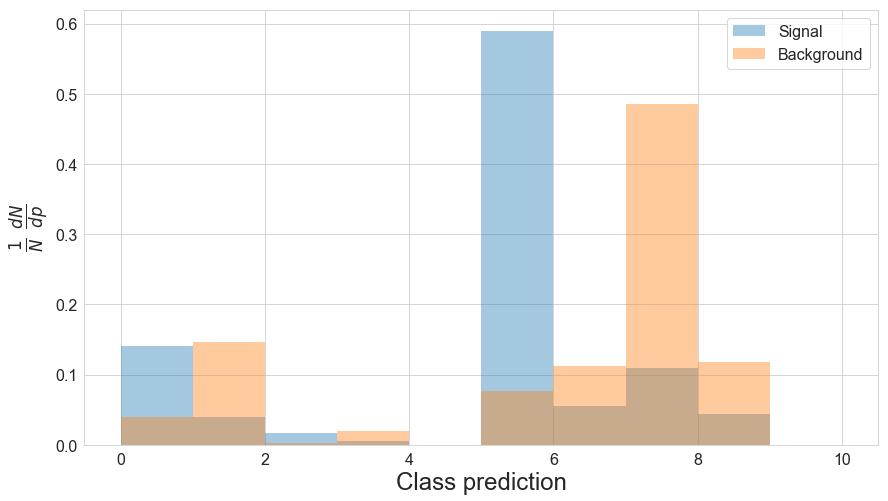

In [11]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [12]:
bin_preds(df)

In [13]:
df.head()

,pred,gen_target,pred_bin
0,0,1.0,0
1,8,1.0,8
2,0,1.0,0
3,5,1.0,5
4,5,1.0,5


In [14]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [15]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [16]:
f_s, f_b

(tensor([1.4077e-01, 3.9792e-02, 1.6250e-02, 5.0860e-03, 2.0000e-13, 5.8997e-01,
         5.5096e-02, 1.0961e-01, 4.3428e-02, 2.0000e-13]),
 tensor([3.9608e-02, 1.4602e-01, 2.0100e-03, 1.9252e-02, 2.0000e-13, 7.5942e-02,
         1.1295e-01, 4.8566e-01, 1.1856e-01, 2.0000e-13]))

In [17]:
asimov = (50*f_s)+(1000*f_b)

In [18]:
asimov, asimov.sum()

(tensor([4.6646e+01, 1.4801e+02, 2.8225e+00, 1.9506e+01, 2.1000e-10, 1.0544e+02,
         1.1571e+02, 4.9114e+02, 1.2073e+02, 2.1000e-10]), tensor(1050.))

In [19]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.97640991, 25.84034348, 25.70979118, 25.58455658, 25.46456909,
       25.34973907, 25.24027634, 25.13562012, 25.03618622, 24.94194603,
       24.85244751, 24.76782799, 24.68792725, 24.61267662, 24.54224777,
       24.47668839, 24.4153595 , 24.3588295 , 24.30686378, 24.25889015,
       24.21571922, 24.17666626, 24.1419487 , 24.11167336, 24.08561325,
       24.06342125, 24.04550171, 24.03142738, 24.02167892, 24.01582718,
       24.01356888, 24.01581192, 24.02161217, 24.03118896, 24.04447937,
       24.06175995, 24.08245277, 24.10706329, 24.13524437, 24.16704941,
       24.20227051, 24.24095535, 24.28321266, 24.32911873, 24.37831306,
       24.43104172, 24.48680115, 24.54610825, 24.60842514, 24.67428207,
       24.74322128, 24.81554031, 24.89105988, 24.96955299, 25.05119705,
       25.1360817 , 25.22360992, 25.3143158 , 25.40788078, 25.5050087 ,
       25.60446548])

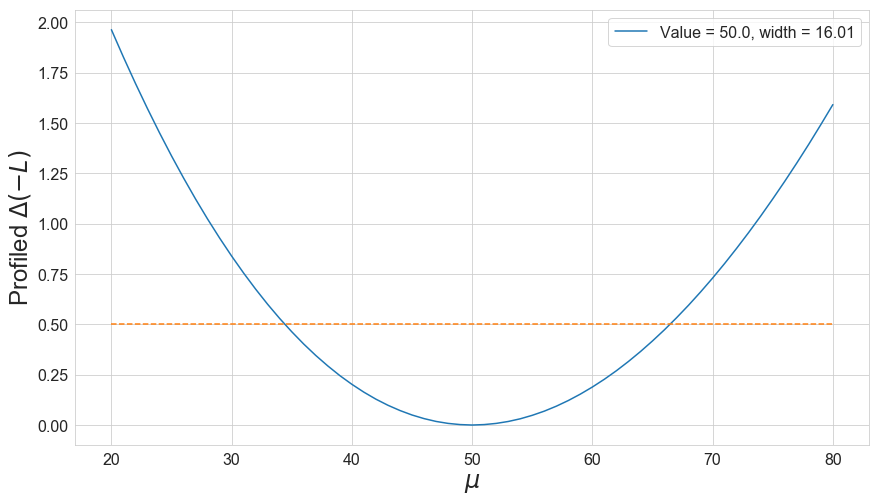

In [20]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [21]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [22]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [23]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0,1.0,0,0,0,0,0,0,0,0,0,0,0
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,0,1.0,0,0,0,0,0,0,0,0,0,0,0
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,5,1.0,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8,0.0,8,8,8,8,8,8,8,7,7,8,8
999996,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999997,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999998,1,0.0,1,1,1,1,1,1,1,1,1,1,1


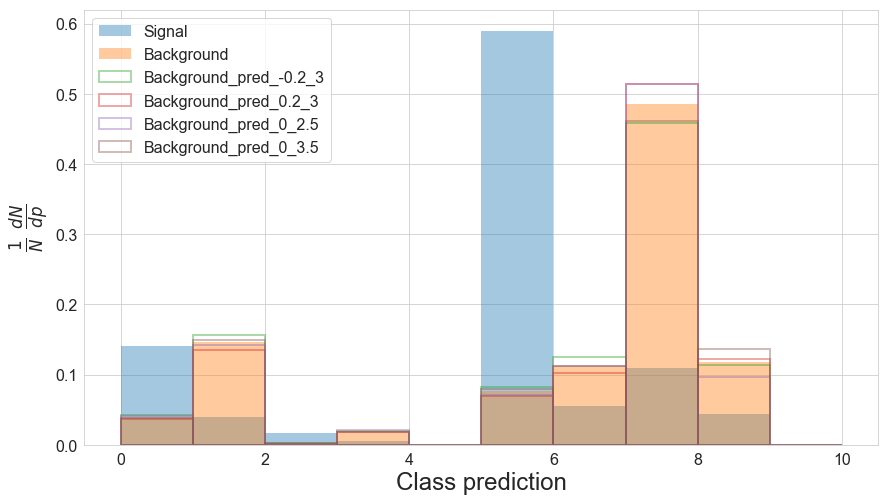

In [24]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([4.3656e-02, 1.5242e-01, 1.5240e-03, 2.1132e-02, 2.0000e-13, 7.8096e-02,
        1.2447e-01, 4.8576e-01, 9.2946e-02, 2.0000e-13])
tensor([4.2486e-02, 1.5633e-01, 2.2660e-03, 1.9672e-02, 2.0000e-13, 8.2416e-02,
        1.2456e-01, 4.5804e-01, 1.1422e-01, 2.0000e-13])
tensor([4.1556e-02, 1.6022e-01, 3.0720e-03, 1.8284e-02, 2.0000e-13, 8.6594e-02,
        1.2456e-01, 4.3308e-01, 1.3263e-01, 2.0000e-13])
tensor([4.0778e-02, 1.4210e-01, 1.2680e-03, 2.0712e-02, 2.0000e-13, 7.1622e-02,
        1.1286e-01, 5.1338e-01, 9.7284e-02, 2.0000e-13])
tensor([3.9608e-02, 1.4602e-01, 2.0100e-03, 1.9252e-02, 2.0000e-13, 7.5942e-02,
        1.1295e-01, 4.8566e-01, 1.1856e-01, 2.0000e-13])
tensor([3.8678e-02, 1.4990e-01, 2.8160e-03, 1.7864e-02, 2.0000e-13, 8.0120e-02,
        1.1295e-01, 4.6069e-01, 1.3697e-01, 2.0000e-13])
tensor([3.7854e-02, 1.3180e-01, 1.0060e-03, 2.0072e-02, 2.0000e-13, 6.4786e-02,
        1.0181e-01, 5.4138e-01, 1.0130e-01, 2.0000e-13])
tensor([3.6684e-02, 1.3572e-01, 1.7480e-0

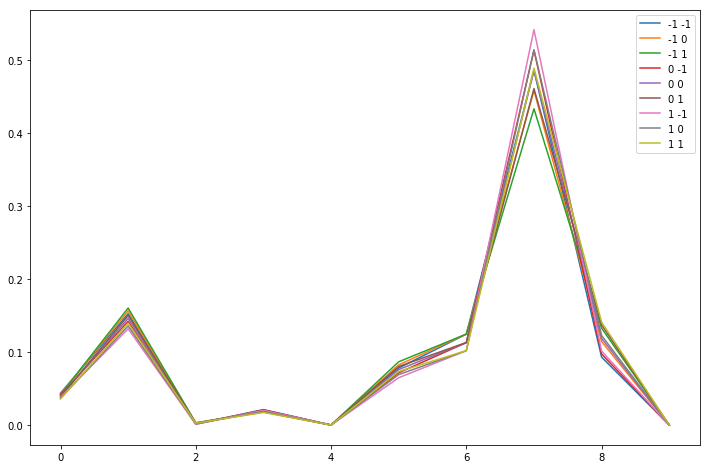

In [25]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [26]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [27]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [28]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [29]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [30]:
nll = to_np(nll)

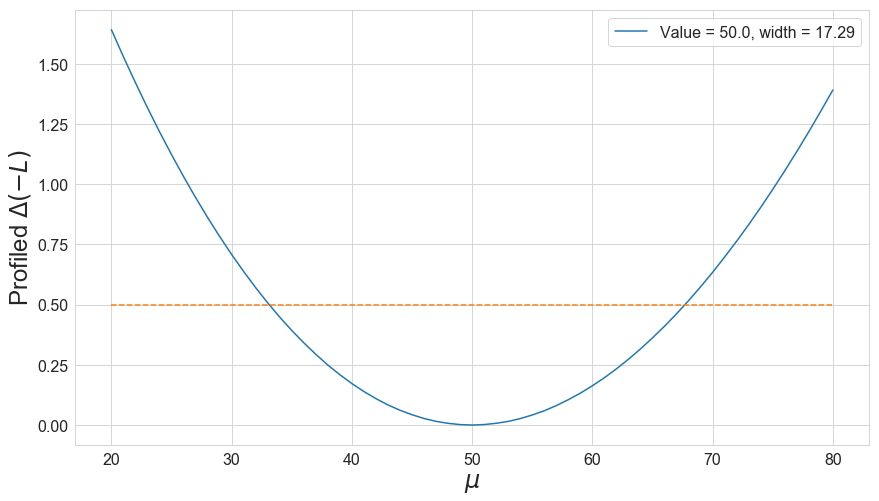

In [31]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [32]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [34]:
nll = to_np(nll)

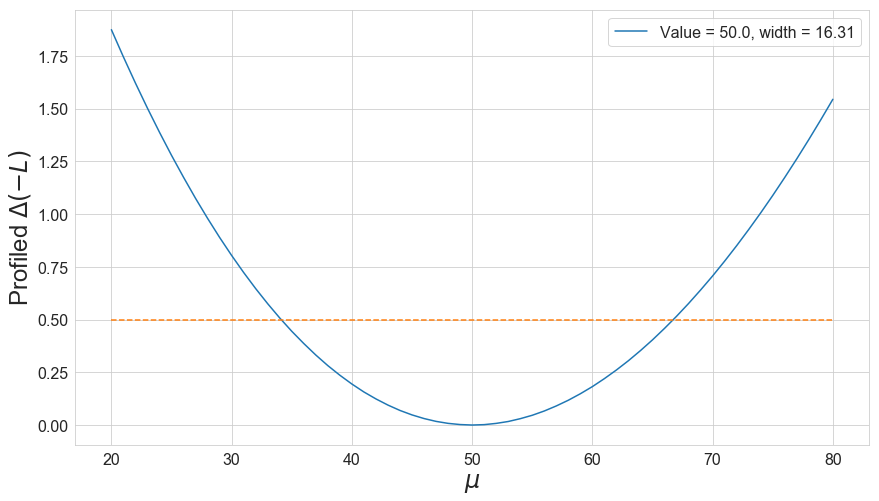

In [35]:
plot_likelihood(nll-nll.min())

## BM 2

In [36]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [37]:
nll = to_np(nll)

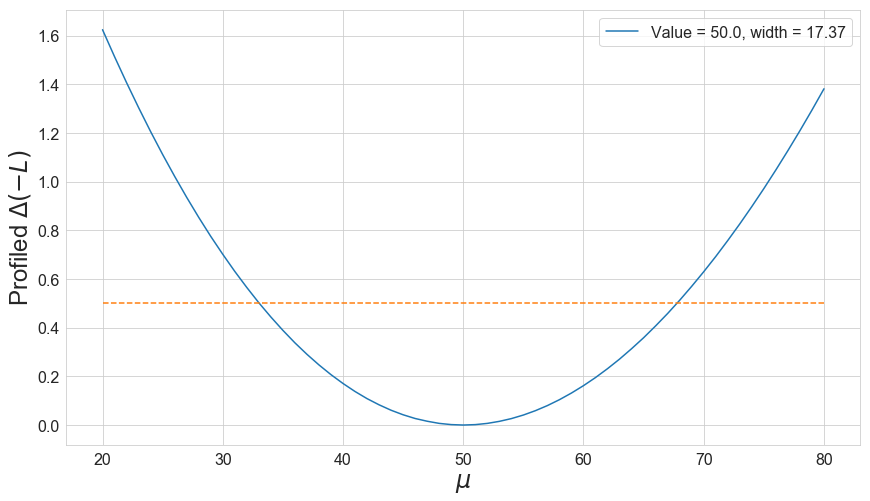

In [38]:
plot_likelihood(nll-nll.min())

## BM 3

In [39]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [40]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [41]:
nll = to_np(nll)

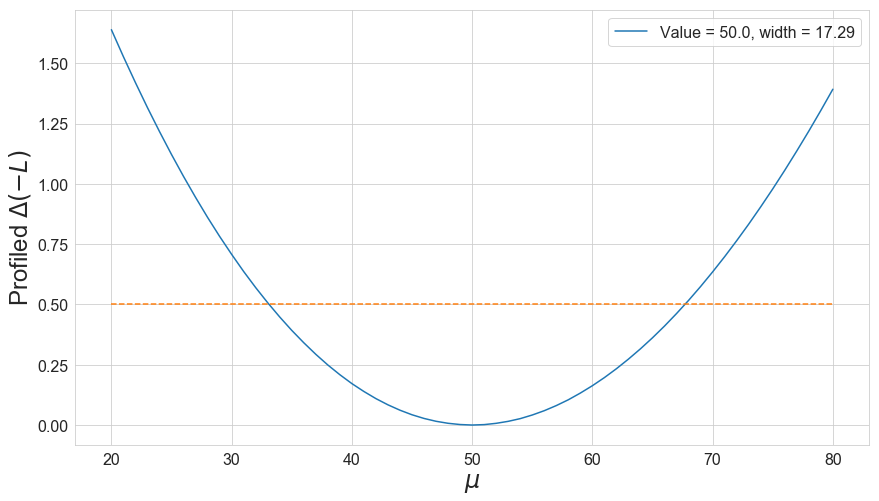

In [42]:
plot_likelihood(nll-nll.min())

## BM 4

In [43]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [44]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3371,  0.0872, 25.6030])
Linear regime: Mu 21.0, alpha tensor([-0.3251,  0.0840, 24.6792])
Linear regime: Mu 22.0, alpha tensor([-0.3132,  0.0807, 23.7606])
Linear regime: Mu 23.0, alpha tensor([-0.3013,  0.0775, 22.8472])
Linear regime: Mu 24.0, alpha tensor([-0.2895,  0.0743, 21.9390])
Linear regime: Mu 25.0, alpha tensor([-0.2778,  0.0712, 21.0359])
Linear regime: Mu 26.0, alpha tensor([-0.2660,  0.0680, 20.1380])
Linear regime: Mu 27.0, alpha tensor([-0.2544,  0.0649, 19.2451])
Linear regime: Mu 28.0, alpha tensor([-0.2428,  0.0619, 18.3572])
Linear regime: Mu 29.0, alpha tensor([-0.2312,  0.0588, 17.4743])
Linear regime: Mu 30.0, alpha tensor([-0.2197,  0.0558, 16.5963])
Linear regime: Mu 31.0, alpha tensor([-0.2082,  0.0528, 15.7231])
Linear regime: Mu 32.0, alpha tensor([-0.1968,  0.0498, 14.8547])
Linear regime: Mu 33.0, alpha tensor([-0.1855,  0.0468, 13.9912])
Linear regime: Mu 34.0, alpha tensor([-0.1742,  0.0439, 13.1324])
Linear reg

In [45]:
nll = to_np(nll)

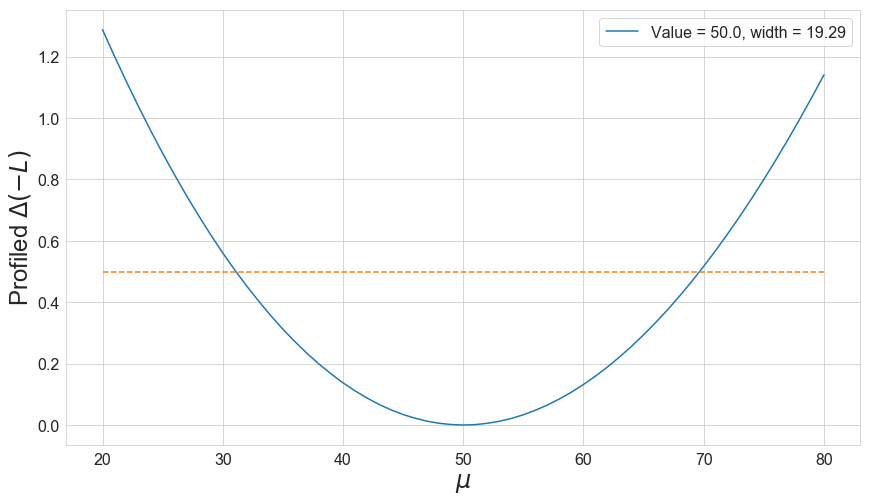

In [46]:
plot_likelihood(nll-nll.min())